In [74]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import os  
from build_DS import find_governing_equations
# checking if the directory demo_folder 
# exist or not.
if not os.path.exists("Plots"):
      
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs("Plots")

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [75]:
class LyapunovModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(LyapunovModel, self).__init__(**kwargs)

    def get_optimizer(self, opt):
        self.opt = opt


    def train_step(self, x_batch_train, vf_batch_train):
        """
        x_batch_train: (n,2)
        vf_batch_train: (n,2)
        """
        # start gradient recording for derivative w.r.t. model parameters
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tapex:
                # prepare for evaluation of x-derivative
                tapex.watch(x_batch_train)
                logits2 = self(x_batch_train) # (n, 1)

            # evaluate x-derivative
            gradx = tapex.gradient(logits2, x_batch_train) # (n,2)

            # evaluate PDE part of loss function

            inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1) # (n,)
            target = tf.square(tf.norm(x_batch_train, ord = 2, axis=1)) # (n,)
            individual_loss = tf.square(tf.abs((inner_product + target))) # (n,)
            loss_value = tf.reduce_sum(individual_loss) / len(x_batch_train) # scalar

        # evaluate derivative w.r.t. model parameters
        # changed this
        grads = tape.gradient(loss_value, self.trainable_weights) # (m, 1)

        # Run one step of gradient descent optimizer
        self.opt.apply_gradients(zip(grads, self.trainable_weights))

        return(loss_value)

    def test_step(self, x_test, vf_test):

        with tf.GradientTape() as tapex:

            tapex.watch(x_test)
            # not sure if training should be false here.
            logits2 = self(x_test, training = False)

        # evaluate x-derivative
        gradx = tapex.gradient(logits2, x_test)
        inner_product = tf.reduce_sum(gradx*vf_test, axis=1) # (n,)
        target = tf.square(tf.norm(x_test, ord = 2, axis=1)) # (n,)
        individual_loss = tf.square(tf.abs((inner_product + target))) # (n,)
        loss_value = tf.reduce_sum(individual_loss) / len(x_test) # scalar
        return loss_value


    def my_fit(self, epochs, tol, train_dataset, validation_dataest):

        all_loss_values = []
        all_test_loss_values = []

        # loop through the epochs
        for epoch in range(epochs):
            # initialize error variable, mlv=maximum (L_infty)
            mlv = 0.0
            
            # Iterate over the batches of the dataset
            # in our case only 1 batch so inly 1 loop here
            all_batch_loss_values = []
            for _, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

                # call optimization routine
                loss_value = self.train_step(x_batch_train, vf_batch_train)
                all_batch_loss_values.append(loss_value.numpy())

                mlv = tf.reduce_max([mlv, loss_value], axis =0)
                # terminate if L_infty error is sufficiently small
                if mlv < tol:
                    break
            all_loss_values.append(np.array(all_batch_loss_values).mean())
            
            all_batch_loss_test_values = []
            for _, (x_test, vf_test) in enumerate(validation_dataest):
                test_loss = self.test_step(x_test, vf_test)
                all_batch_loss_test_values.append(test_loss.numpy())
            all_test_loss_values.append(np.array(all_batch_loss_test_values).mean())

            
            

            if epoch % int(epochs/5) == 0:
                print('epoch %2s, train loss %10.6f, test loss %10.6f' % (epoch, float(loss_value), float(test_loss)))
                
        return all_loss_values, all_test_loss_values

In [76]:
class build_lyapunov():

    def __init__(self, func, dim, bounds, m, epochs, tol) -> None:
        self.func = func
        self.bounds = bounds
        self.dim = dim
        self.m = m
        self.epochs = epochs
        self.tol = tol

    def create_dataset(self, n_x, n_y, dim, bounds, batch_n, buff = None, train = True, plot=False):
        if train == True:
            x = np.linspace(-bounds[0], bounds[0], n_x)
            y = np.linspace(-bounds[1], bounds[1], n_y)
        else:
            x = np.random.uniform(-bounds[0], bounds[0], n_x)
            y = np.random.uniform(-bounds[1], bounds[1], n_y)
        X, Y = np.meshgrid(x, y)
        s = X.shape
        data = np.zeros((n_x*n_y,dim)) 

        # convert mesh into point vector for which the model can be evaluated
        c = 0
        for i in range(s[0]):
            for j in range(s[1]):
                data[c,0] = X[i,j]
                data[c,1] = Y[i,j]
                c = c+1;
        data_points = tf.constant(data, tf.float32) # (n_y, dim)
                        
        input_RHS =  tf.transpose(tf.convert_to_tensor(self.func(data_points), dtype=tf.float32))  # (n_y, dim)

        dataset_raw = tf.data.Dataset.from_tensor_slices((data_points, input_RHS))
        if buff:
            dataset_raw = dataset_raw.shuffle(buffer_size=buff)
        dataset = dataset_raw.batch(batch_n)

        if plot:
            plt.scatter(data_points[:,0], data_points[:,1])
            plt.savefig('Plots/dataset_train_{}.pdf'.format(train))
            plt.show()

        return dataset, data_points, input_RHS

    def get_regularised_bn_mlp(self, act, hidden_units, keras_model, opt, train=False):
        """
        This function is used to build the MLP model. It takes input_shape and hidden_units
        as arguments, which should be used to build the model as described above, using the
        functional API.
        """
        inputs = tf.keras.layers.Input(shape=(self.dim,), name = 'state')
        h = tf.keras.layers.Dense(self.m, activation=act, 
                                kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=1),
                                bias_initializer= tf.random_uniform_initializer(0, 2* np.pi), 
                                trainable=train, name = '1st_hidden')(inputs)
        h = np.sqrt(2) * h 
        for units in hidden_units:
            h = tf.keras.layers.Dense(units, activation='linear')(h)
        # use bias is false because the derivative of a constant number (bias) is just zero
        outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
        outputs = outputs / self.m 
        model = keras_model(inputs=inputs, outputs=outputs)
        model.get_optimizer(opt)
        self.model = model
        return model

    def plot_Layer(self, numpoints):
        """
        Simply plot the Layer without any training to 
        see its initial state and compare with actual Gaussian kernel
        """
        x = np.linspace(-self.bounds[0], self.bounds[0], numpoints)
        y = np.linspace(-self.bounds[1], self.bounds[1], numpoints)

        X, Y = np.meshgrid(x, y)

        s = X.shape

        Ze = np.zeros(s)
        Zp = np.zeros(s)
        DT = np.zeros((numpoints**2,self.dim))

        # convert mesh into point vector for which the model can be evaluated
        c = 0
        for i in range(s[0]):
            for j in range(s[1]):
                DT[c,0] = X[i,j]
                DT[c,1] = Y[i,j]
                c = c+1;

        intermediate_output1 = tf.keras.Model(self.model.input, self.model.get_layer('1st_hidden').output)

        x1 = tf.zeros(DT.shape, tf.float32) # (n**2, 2)
        x2 = tf.constant(DT, tf.float32) # (n**2, 2)
        phi_1 = intermediate_output1(x1) # (n**2, m)
        phi_2 = intermediate_output1(x2) # (n**2, m)
        k_nn = tf.reduce_sum(phi_1*phi_2, axis=1) / self.m # (n**2,) Eq. 22 paper
        k_nn = tf.reshape(k_nn, (numpoints, numpoints)) # (n, n)

        g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
        kernel_sol = g_kernel.apply(x1, x2) # (n**2,)
        kernel_sol = tf.reshape(kernel_sol, (numpoints,numpoints)) # (n,n)

        plt.figure(figsize=(10, 8))
        plt.subplot(121)
        plt.title('Actual Gasussian Kernel')
        cp1 = plt.contour(x,y, kernel_sol, levels=10);
        plt.clabel(cp1, inline=True, fontsize=10)

        plt.subplot(122)
        plt.title('Neural Network Kernel')
        cp2 = plt.contour(x,y, k_nn, levels=10)
        plt.clabel(cp2, inline=True, fontsize=10)

        plt.savefig('Plots/NN_Kernel_m_{}.pdf'.format(self.m))
        plt.show()

    def fit(self, train_dataset, test_dataset, plot = False):
        all_loss_values, all_test_loss_values = self.model.my_fit(self.epochs, self.tol, train_dataset, test_dataset)
        if plot:
            plt.plot(all_loss_values, label = 'train loss')
            # plt.xscale('log')
            plt.plot(all_test_loss_values, label = 'validation loss')
            plt.title("Loss vs iterations with m = {}".format(self.m))
            plt.xlabel("Iterations")
            plt.ylabel("MSE loss")
            plt.legend()
            # plt.xscale('log')
            plt.savefig('Plots/Loss_Curve_m_{}.pdf'.format(self.m))
            plt.show()
        return all_loss_values, all_test_loss_values

    def plot_solution(self, numpoints):
        ###### plot result ######

        # define plotting range and mesh
        x = np.linspace(-self.bounds[0], self.bounds[0], numpoints)
        y = np.linspace(-self.bounds[1], self.bounds[1], numpoints)

        X, Y = np.meshgrid(x, y)

        s = X.shape

        Ze = np.zeros(s)
        Zp = np.zeros(s)
        DT = np.zeros((numpoints**2,self.dim))

        # convert mesh into point vector for which the model can be evaluated
        c = 0
        for i in range(s[0]):
            for j in range(s[1]):
                DT[c,0] = X[i,j]
                DT[c,1] = Y[i,j]
                c = c+1;

        # evaluate model (= Lyapunov function values V)
        Ep = self.model.predict(DT)
        intermediate_output2 = tf.keras.Model(self.model.input, self.model.get_layer('output_layer').output)


        # convert point vector to tensor for evaluating x-derivative
        tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

        # evaluate gradients DV of Lyapunov function
        with tf.GradientTape() as tape:
            tape.watch(tDT)
            ypm = self.model(tDT)
            grads = tape.gradient(ypm, tDT)

        # compute orbital derivative DVf
        Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(self.func(DT), dtype=tf.float32)), axis=1)

        # copy V and DVf values into plottable format
        c = 0
        for i in range(s[0]):
            for j in range(s[1]):
                Ze[i,j] = Ee[c]
                Zp[i,j] = Ep[c]
                c = c+1;


        # define vector field for plot
        new_vf = np.reshape(np.array(self.func(DT)), (self.dim, numpoints, numpoints))

        # define figure
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')

        # ax.set_title('m = {}'.format(m))
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('DV, V');

        # plot values V
        ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')

        # plot orbital derivative DVf
        ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

        # change angles to see graph more clearly
        # ax.view_init(-140, 60)
        ax.view_init(10, 60)

        plt.savefig('Plots/van_3dplot_m_{}.pdf'.format(self.m))
        # plt.show()

        plt.figure(figsize=(5,8))
        cp = plt.contour(x,y,Zp, levels=8)
        plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
        plt.clabel(cp, inline=True, fontsize=10)
        plt.title('m = {}'.format(self.m))
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.savefig('Plots/vanpol2_m_{}.pdf'.format(self.m))
        plt.show()


In [77]:
hidden_u = []
m = 100
dim = 2
bounds = [1.6, 4]
n_x = 6
n_y = 15
batch_n = n_x*n_y
buff = None
epochs = 1000
tol = 1e-3
act = tf.math.cos
# act = 'relu'
train = False
opt = tf.keras.optimizers.SGD(learning_rate=m*0.1, nesterov=True)
# opt = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
# opt = tf.keras.optimizers.Adam(0.01)
use_true_equation = True
# time series hyperparameters
dt = 0.01
init= [0, 2]
t_end = 20
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y
# also define 1d van der pool for time series
# Van der Pol ODE
def van_der_pol(t, x, p=[1]):
    return [-x[1], - p[0] * (1 - x[0] ** 2) * x[1] + x[0]]

if not use_true_equation:
    GE = find_governing_equations(func = van_der_pol, dt= dt)
    GE.create_time_series(t_end = t_end, init = init)
    model = GE.find_equations(verbose = True)

    def approx_vf(x):
        if type(x) != np.ndarray:
            x = x.numpy()
        return model.predict(x).T

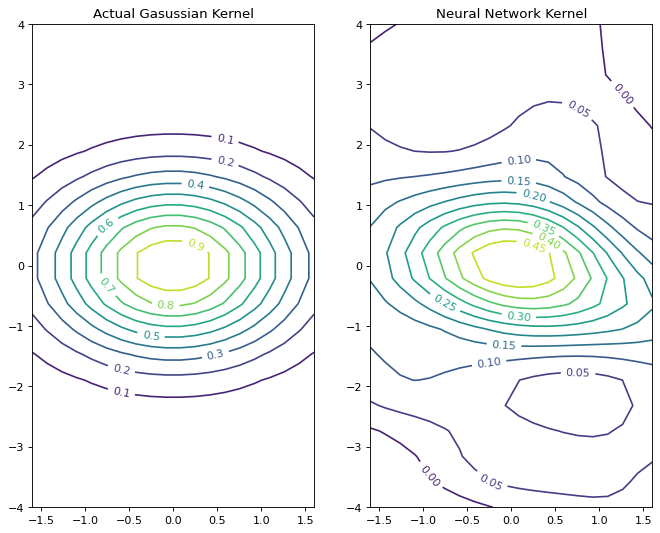

epoch  0, train loss  83.510109, test loss 149.229980
epoch 200, train loss   3.496407, test loss   1.073829
epoch 400, train loss   2.735368, test loss   0.561440
epoch 600, train loss   2.481048, test loss   0.463133
epoch 800, train loss   2.321109, test loss   0.450353


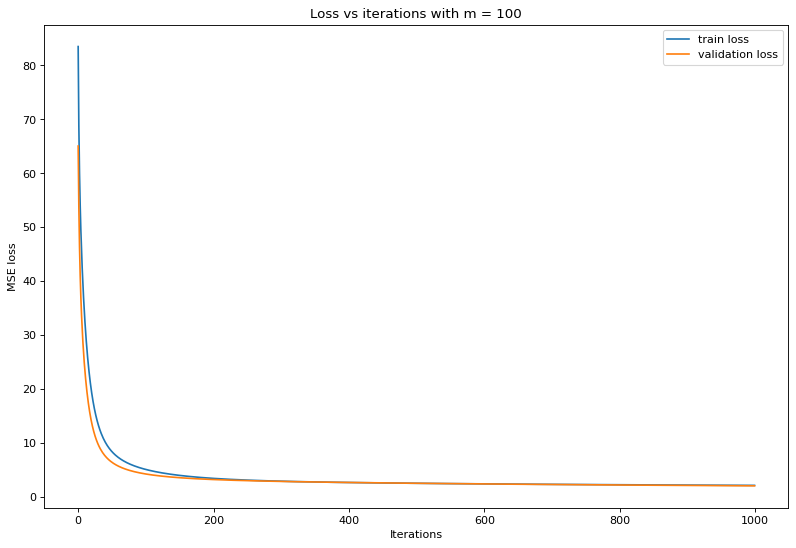

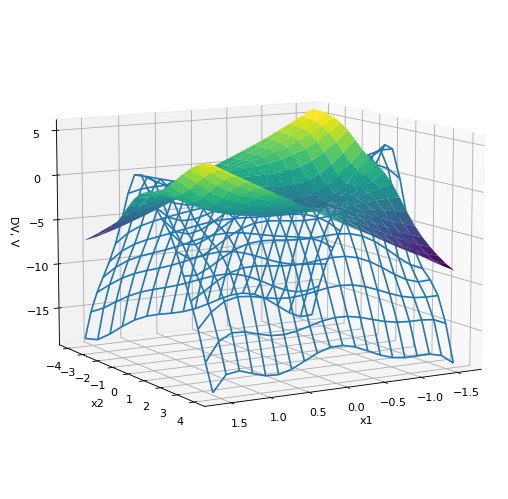

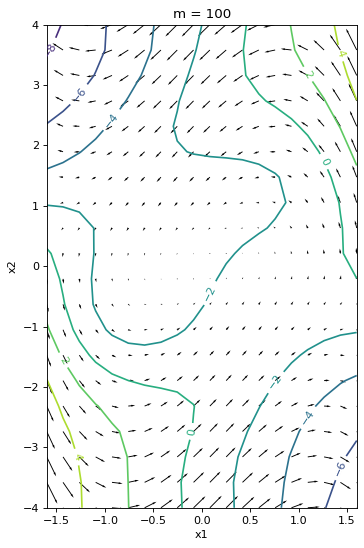

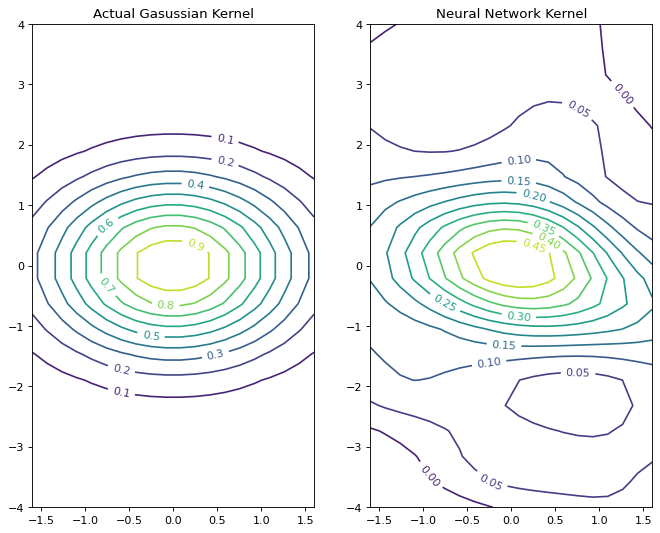

In [78]:
builded = build_lyapunov(vf, dim, bounds, m, epochs, tol)
train_dataset, train_data_points, train_input_RHS = builded.create_dataset(n_x, n_y, 
                                dim, bounds, batch_n, buff = None, train = True, plot=False)
test_dataset, test_data_points, test_input_RHS = builded.create_dataset(15, 25, 
                                dim, bounds, batch_n, buff = None, train = False, plot=False)
my_mlp = builded.get_regularised_bn_mlp(act, hidden_u, LyapunovModel, opt= opt,  train=train)
# print(my_mlp.summary())

builded.plot_Layer(20)
builded.fit(train_dataset, test_dataset, plot=True)
builded.plot_solution(20)
builded.plot_Layer(20)